### Data Description

This dataset contains an anonymized set of features, feature_{0...129}, representing real stock market data. Each row in the dataset represents a trading opportunity, for which you will be predicting an action value: 1 to make the trade and 0 to pass on it. Each trade has an associated weight and resp, which together represents a return on the trade. The date column is an integer which represents the day of the trade, while ts_id represents a time ordering. In addition to anonymized feature values, you are provided with metadata about the features in features.csv.

In the training set, train.csv, you are provided a resp value, as well as several other resp_{1,2,3,4} values that represent returns over different time horizons. These variables are not included in the test set. Trades with weight = 0 were intentionally included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation.

This is a code competition that relies on a time-series API to ensure models do not peek forward in time. To use the API, follow the instructions on the Evaluation page. When you submit your notebook, it will be rerun on an unseen test:

During the model training phase of the competition, this unseen test set is comprised of approximately 1 million rows of historical data.
During the live forecasting phase, the test set will use periodically updated live market data.
Note that during the second (forecasting) phase of the competition, the notebook time limits will scale with the number of trades presented in the test set. Refer to the Code Requirements for details.

### Utility Score Definition
This competition is evaluated on a utility score. Each row in the test set represents a trading opportunity for which you will be predicting an action value, 1 to make the trade and 0 to pass on it. Each trade j has an associated weight and resp, which represents a return.

pi=∑j(weightij∗respij∗actionij),
 
t=(∑pi/sqrt(∑pi_square)*sqrt(250/|i|)
 
where (|i|) is the number of unique dates in the test set. The utility is then defined as:

u=min(max(t,0),6)∑pi.

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
import optuna
import matplotlib.gridspec as gridspec
from collections import defaultdict

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [16]:
# Import dataset as train
df = pd.read_csv("C:/Users/KWANG/Desktop/ML study/Data science_2020/Project/Jane Street prediction/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.5 GB


Reduce the memory usage by switching float 64 to float32.

In [32]:
float64_cols = df.select_dtypes(include='float64').columns
mapper = {col_name: np.float32 for col_name in float64_cols}
df = df.astype(mapper)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float32(135), int64(3)
memory usage: 1.3 GB


In [17]:
df.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,...,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,...,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-1,0.812780,-0.256156,...,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,2
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-1,1.174378,0.344640,...,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,3
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,...,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4


In [39]:
#MemoryError: Unable to allocate 7.37 GiB for an array with shape (2390491, 138, 3) and data type float64

#import missingno as msno
#msno.matrix(df)

In [18]:
df.ts_id.unique()

array([      0,       1,       2, ..., 2390488, 2390489, 2390490],
      dtype=int64)

- Intraday high frequency trading suggests ts_id likely represents packet number of commodity in stock exchange.
- Usually the main type of these packets are about Trade, Delete, update, Reduce Messages/ Packets about changes in limit order book.

In [19]:
df.sort_values(by= ['date','ts_id'],inplace=True)

Let's look at the first day of data after sorting.

In [20]:
sample_df = df.query('date == 0')

In [24]:
sample_df.describe()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
count,5587.0,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,5587.000000,...,5437.000000,5587.000000,5587.000000,5552.000000,5552.000000,5566.000000,5566.000000,5583.000000,5583.000000,5587.000000
mean,0.0,2.004706,0.000020,0.000036,0.000460,0.002755,0.002285,0.020226,0.704028,-0.595923,...,-0.677243,1.021091,-0.448813,0.968835,-0.729380,1.243077,-0.513070,1.130553,-0.436875,2793.000000
std,0.0,5.756178,0.011050,0.014902,0.027288,0.035080,0.028258,0.999885,2.824716,1.820124,...,1.979969,2.308991,1.722394,1.942894,2.181850,2.749516,1.651623,2.529628,1.543382,1612.972308
min,0.0,0.000000,-0.162525,-0.169475,-0.194096,-0.216788,-0.168365,-1.000000,-3.172026,-3.093182,...,-4.627423,-3.403865,-5.840817,-2.555008,-5.508258,-5.227604,-4.147819,-4.343418,-4.539052,0.000000
25%,0.0,0.140324,-0.002389,-0.003208,-0.005854,-0.010292,-0.008602,-1.000000,-1.140409,-1.891450,...,-2.067119,-0.639434,-1.642131,-0.575153,-2.189492,-0.888733,-1.589927,-0.757779,-1.460930,1396.500000
50%,0.0,0.555322,0.000127,0.000177,0.000113,0.000254,0.000443,1.000000,0.246513,-0.921463,...,-1.025158,0.686730,-0.604014,0.742550,-1.117136,1.009463,-0.780900,0.820666,-0.607440,2793.000000
75%,0.0,1.738934,0.002804,0.003975,0.007504,0.013043,0.010518,1.000000,2.035431,0.348254,...,0.265478,2.229159,0.383870,2.057701,0.217006,2.889072,0.186400,2.529920,0.273084,4189.500000
max,0.0,119.137190,0.126417,0.147485,0.177192,0.194283,0.180969,1.000000,31.945752,17.109695,...,12.135365,16.484804,12.614915,12.639668,23.017784,16.897999,18.969491,16.123469,12.143004,5586.000000


- There are many features with less than 5587 full count of data in date 0.
- With these missing values, replace them with mean value utilizing the zero/mean reversion strategy.

In [26]:
sample_df = sample_df.apply(lambda x: x.fillna(x.mean()), axis=0)

Plot the histogram for all the features in the sample_df dataset of the date=0.

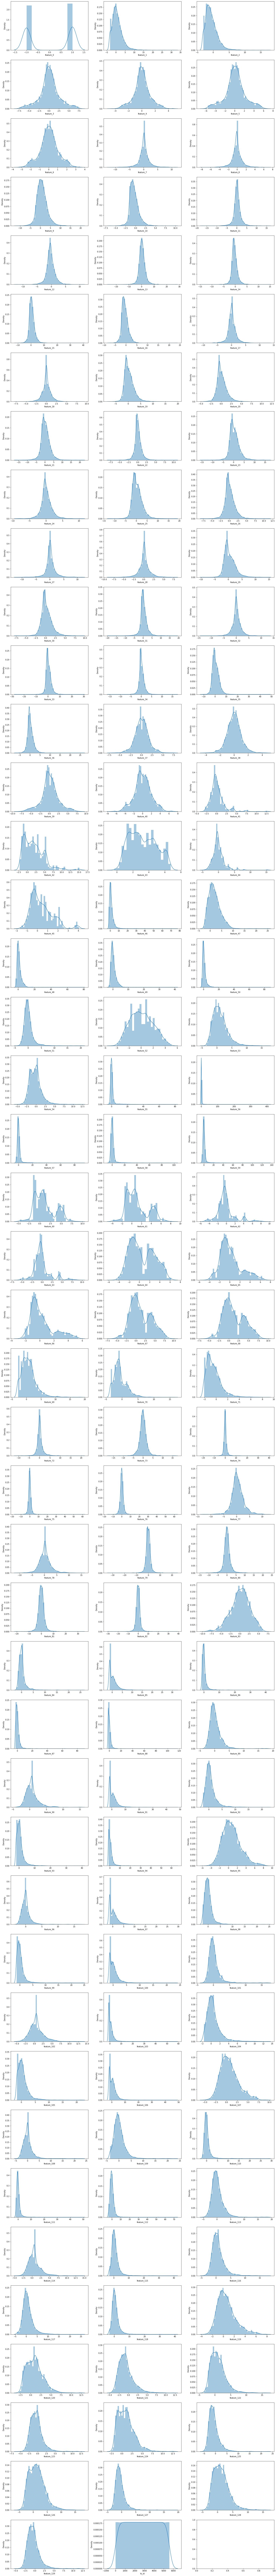

In [27]:
fig, axes = plt.subplots(nrows=44, ncols=3, figsize=(25, 250))
for i, column in enumerate(sample_df.iloc[:,7:].columns):
    sns.distplot(sample_df[column],ax=axes[i//3,i%3])

- The distribution of each feature shown in the plots show that most of the features are normally distributed and reverted to zero.
- It'd be easier to group these features into different categories.
- Two main approaches used for trading are:
    - Momentum based strategy: predicts the prices will continue in the same direction.
    - Zero/Mean reverted strategy: betting that prices will revert back towards the mean or average
- The feature 0 looks like a signal (which gives indication such as volume imbalance in Limit Order Book. It provides info about whether buy side or ask side has more volume)

### Weight
- I'll analyze the distribution of feature weight.
- Assuming this weight feature would be based on risk/volatility concept. This means the weight is a variable given by the risk department that caps the maximum amount of money that a trader can invest in the asset.
    - If an asset is too risky, the risk department would attribute a weight of zero to that asset at the beginning of the day before the open market. This would make the trader unable to buy that asset. 
    - If an asset is somewhat risky, it would have a weight of perhaps 0.25. This means an asset fund with 100M could invest 25M in the asset. 
    - If the weight is higher than 1, say 1.25, the same fund could invest 100M and borrow additional 25M from the market to invest in the asset.
- The feature could also be based on volume parameters as volumes generally play a big role in trading.

<AxesSubplot:xlabel='weight', ylabel='Density'>

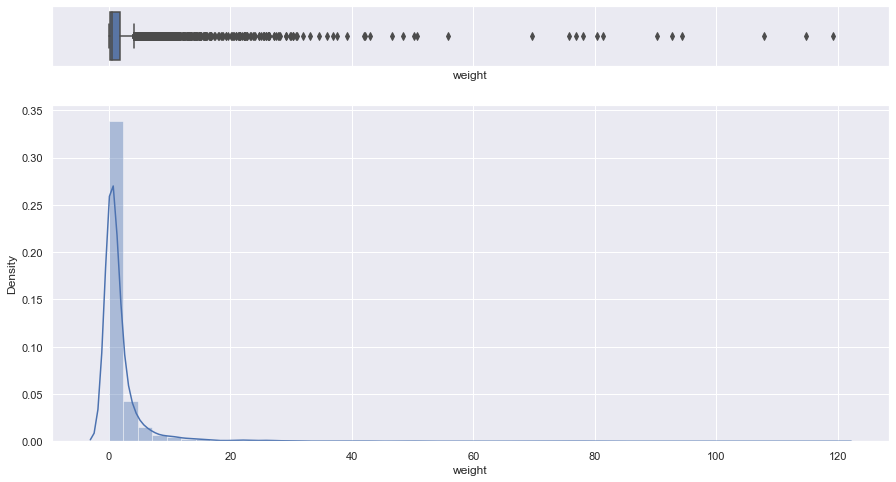

In [31]:
sns.set(rc={'figure.figsize':(15,8)})
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios':(.15, .85)})

sns.boxplot(sample_df['weight'], ax=ax_box)
sns.distplot(sample_df['weight'], ax=ax_hist)

- The chart above shows the most trades on day 0 have zero weight as the median is close to zero.
- The competition description mentioned that "Trades with weight 0... will not contribute towards the scoring evaluation."

### Resp
- In the competition description, we need to predict the action of 1 to trade and 0 to pass. However, the action variable is not given in the train set. 
- Based on some discussion threads, the resp variable is assumed to be predictive variable.

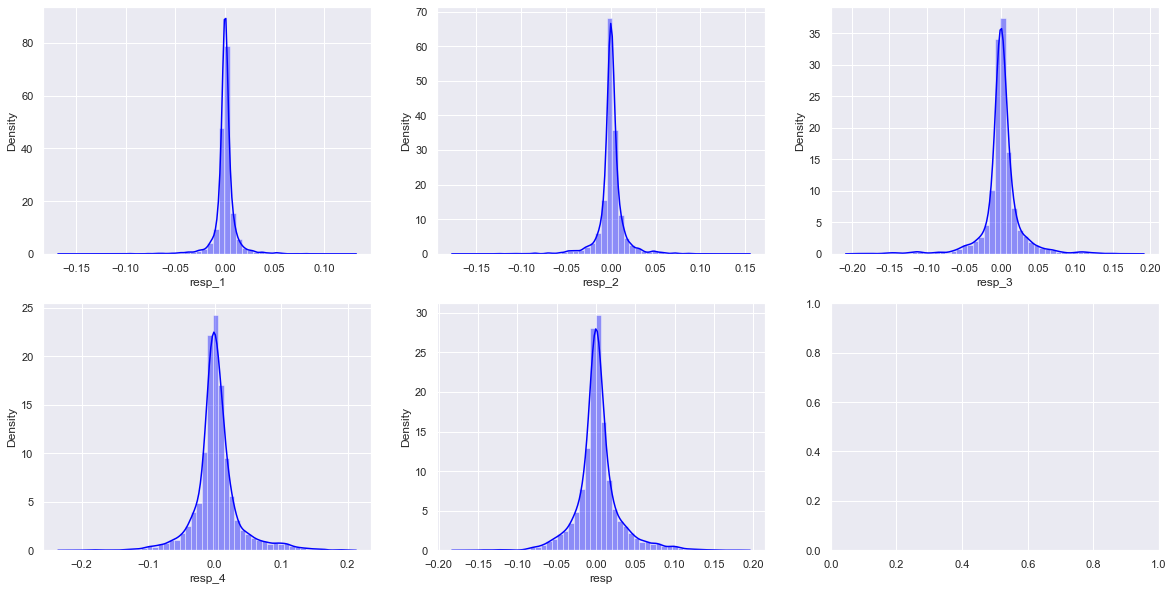

In [44]:
resp_df = sample_df.iloc[:, 2:7]     #resp features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
for i, column in enumerate(resp_df.columns):
    sns.distplot(sample_df[column], ax=axes[i//3,i%3],color='blue')

- The plots above show that the distribution of all the resp features are perfectly normalized around 0 (zero reverted).
- The competition discussion writes that: 
    - "The only response variable in evaluation is Resp (see the evaluation metric), Resp1 - Resp4 only exists in the train.csv, they are correlated to Resp but not exactly the same (see the data description). They are provided just in case some people want some alternative objective metrics to regularize their model training."
- Thus, we can deduce that the only 'resp' feature would be the main evaluation metric.
- Resp1 - Resp4 features would be the exptensions of Resp. They can be used to regularize model training later.

<AxesSubplot:>

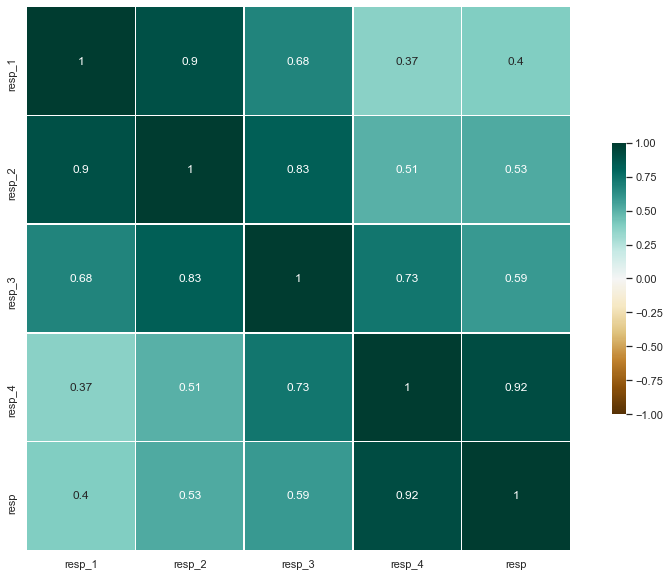

In [45]:
corr = resp_df.corr()
#set up the matplotlib fiture
f, ax = plt.subplots(figsize=(15,10))
#draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='BrBG', center=0,vmin=-1,vmax=1, annot=True, square=True, linewidths=0.5, cbar_kws={'shrink':0.5})

- The correlation heatmap above shows that resp_4 has the highest positive correlation of 0.92 with 'resp' feature.
- The resp_1 has the lowest positive correlation with 'resp'.

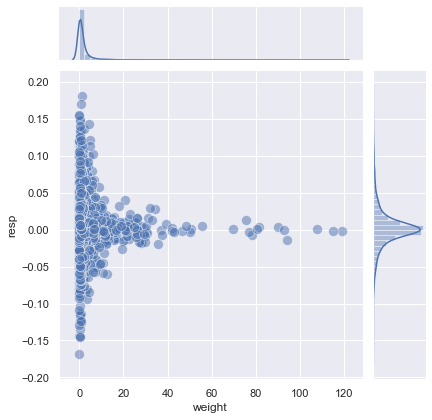

In [46]:
# weight vs. resp in Day 0
g = sns.JointGrid(data=sample_df, x='weight', y='resp')
g.plot_joint(sns.scatterplot, s=100, alpha=0.5)
g.plot_marginals(sns.distplot, kde=True)

- The weight vs. resp chart for Day 0 shows that some trades have weights close to 120.
- It's good to divide these trades into 3 categories with weights of x<40, 40<x<80, x>80. This task will be done in later sections.

### Testing the p, t, u equations

- Then we could assume the return p in each trade is represented by weight * resp * action. If we have 10 trades for each date, then we would take the sum for all those 10 trades, which would be our P. If there are 5 unique dates in the dataset, then we have 5P with us. 
- The t value is calculated as 

pi=∑j(weightij∗respij∗actionij),

Summation of P / (square root of summation of squares of P) * sqrt(250/5)

t=(∑pi/sqrt(∑pi_square)*sqrt(250/|i|)

#### pi (test the potential return for day 0) 
- Each row or trading opportunity can be chosen (action == 1) or not (action == 0).
- The variable  pi  is a indicator for each day  i , showing how much return we got for that day.
- Let's say we end up choosing all transactions for day 0. We would have: pi=∑j(weightij∗respij∗1)

In [33]:
# If all transactions are chosen
sample_df['mult'] = sample_df['weight']*sample_df['resp']*1
p_0 = sample_df['mult'].sum()
p_0

12.045550816445324

In [35]:
sample_df['resp']>0

0        True
1       False
2        True
3       False
4       False
        ...  
5582     True
5583     True
5584     True
5585     True
5586     True
Name: resp, Length: 5587, dtype: bool

If we want to maximize return, we would only choose the transactions that give us a positive return.
Try this approach for day 0.

In [34]:
# Highest possible p for day 0
# 5586 transacitons in day 0. For each row, sample_df['resp']>0 produces True/False depending on the value of resp.
sample_df['mult'] = sample_df['weight']*sample_df['resp']*(sample_df['resp']>0)
p_0 = sample_df['mult'].sum()
p_0

74.55811669838056

- To maximize u, we need to maximize pi. 
- To do that, we have to select the least amount of negative resp values as possible (it is the only value that would make the total sum of p decreasing)
- And maximize the positive number of positive resp transactions we select.

#### Understanding t
If we have two days to compose t,
- First scenario: 
     - Day0 : p0=74
     - Day1 : p1=2
 
where,  ∑pi=76 . If we calculate  t  for this scenario we would have:

t=(∑pi/sqrt(∑pi_square)*sqrt(250/|i|)

In [40]:
t = (np.sum(np.array([74,2])/np.sqrt(np.sum(np.array([74,2])**2))))*np.sqrt(250/2)
t    

11.47831977327336

The second scenario also has ∑pi=76 but with different values.
- Second scenario:
    - Day0 : p0=38
    - Day1 : p1=38

In [41]:
t = (np.sum(np.array([38,38])/np.sqrt(np.sum(np.array([38,38])**2))))*np.sqrt(250/2)
t   

15.811388300841896

- The insight behind the comparison of the two scenarios above is that t is larger when the return for each day is better distributed with lower variation.
- It's better to have returns uniformly divided among many days than to have all the returns concentrated in few days.
- It is somewhat similar to L1 vs. L2 situation where the L2 norm penalizes outliers more than L1.

- There is one more thing to consider in the t equation. 
- We have a multiplying factor of sqrt(250/|i|).
- So, basically, the higher i is,the lower the t value will be.

Let's assume we have 3 days with returns. 
    
    - Day0 : p0=38
    - Day1 : p1=38
    - Day2 : p1=0

In [42]:
t = (np.sum(np.array([38, 38, 0])/np.sqrt(np.sum(np.array([38,38, 0])**2))))*np.sqrt(250/3)
t

12.909944487358056

- The above calculation shows that we get a lower t value than the 2-day scenario calculations.
- We get a penalty for choosing too many dates represented by |i|.
- So the strategy is selecting uniformly distributed positive returns in few dates.

The final utility function equation is u=min(max(t,0),6)∑pi.

- The final equation indicates that the variable t, would only matter if it is lower than 6. Otherwise, t would be replaced by the number 6.

#### A deeper understanding of the utility function
- t is simply the annualized sharpe ratio assuming there are 250 trading days in a year. The sharpe ratio is an important risk adjusted performance measure in investing.
- If sharp ratio is negative, utility is zero.
- A sharpe ratio higher than 6 is very unlikely, so it is capped at 6.
- The utility function tries to maximize the product of sharpe ratio (min(max(t,0),6)) and total return (∑pi).
- As long as t>= 6, we need to maximize the return first.